In [ ]:
cd .. 

In [3]:
import numpy as np
import pandas as pd
import time
import pickle as pkl
import lightgbm as lgb
import itertools

from src.utils.helpers import *
from src.utils.eda_helpers import *
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV,StratifiedKFold
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, log_loss, f1_score, precision_recall_curve, make_scorer

import warnings 
warnings.filterwarnings("ignore")  # To ignore any warnings 

seed = 123
pd.options.display.max_rows = 10 

In [4]:
features_df_raw = pd.read_csv('./data/features.csv')
features_df = features_df_raw.copy()
labels_df_raw = pd.read_csv('./data/labels.csv')
labels_df = labels_df_raw.copy()

In [6]:
features_df.head()

,trackID,title,tags,loudness,tempo,time_signature,key,mode,duration,vect_1,...,vect_139,vect_140,vect_141,vect_142,vect_143,vect_144,vect_145,vect_146,vect_147,vect_148
0,6654,Beside the Yellow Line,"i, the, to, and, a, me, it, not, in, my, is, o...",-8.539,104.341,3.0,7.0,1.0,298.73587,44.462048,...,0.000308,0.000302,0.000302,0.000315,0.000297,0.000305,0.000266,0.000225,0.130826,1.071914
1,5883,Ooh Na Na,"i, you, to, and, a, me, it, not, in, my, is, y...",-4.326,141.969,3.0,6.0,0.0,236.09424,46.069761,...,0.001751,0.001855,0.001920,0.001950,0.001937,0.001912,0.001836,0.001740,0.148765,0.882304
2,3424,Calabria 2008,"i, the, you, to, and, a, me, it, not, in, of, ...",-9.637,126.003,4.0,10.0,0.0,412.94322,40.376622,...,0.000951,0.001039,0.001116,0.001166,0.001159,0.001110,0.001015,0.000895,0.116206,0.306846
3,5434,Verbal Abuse (Just an American Band),"i, you, to, and, a, me, it, not, my, is, your,...",-10.969,197.625,4.0,2.0,1.0,64.78322,45.598532,...,0.000233,0.000284,0.000313,0.000325,0.000324,0.000299,0.000273,0.000236,0.163738,1.247803
4,516,Helen Of Troy,"i, the, to, a, me, it, not, in, is, your, we, ...",-5.369,170.008,4.0,0.0,1.0,191.97342,47.159148,...,0.000853,0.000927,0.000994,0.001037,0.001051,0.001011,0.000962,0.000898,0.108193,0.366419


In [7]:
features_df.isnull().sum()/len(features_df)*100
# some missing values. but since they're make up a small pct of total dataset, will drop them for 
# this mvp model. 
# next steps: can impute categorical features that have nulls with mode, 
# numerical features with mean if the feature's distribution follows a normal distribution. 
# if the numerical feature's distribution is skewed, impute nulls with median. 

trackID     0.000000
title       0.086122
tags        0.147638
loudness    0.123031
tempo       0.135335
              ...   
vect_144    0.000000
vect_145    0.000000
vect_146    0.000000
vect_147    0.000000
vect_148    0.000000
Length: 157, dtype: float64

In [8]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Columns: 157 entries, trackID to vect_148
dtypes: float64(154), int64(1), object(2)
memory usage: 9.7+ MB


In [9]:
features_df.select_dtypes(include = ['float64']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Columns: 154 entries, loudness to vect_148
dtypes: float64(154)
memory usage: 9.5 MB


In [10]:
features_df.select_dtypes(include = ['int64']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   trackID  8128 non-null   int64
dtypes: int64(1)
memory usage: 63.6 KB


In [11]:
numeric_feat = features_df.select_dtypes(include = ['float64']).columns
int_feat = features_df.select_dtypes(include = ['int64']).columns

In [75]:
len(numeric_feat)

154

In [13]:
# convert data type of numeric columns in features_df to float16. quantization 
# convert id col to int16 instead of int8 to preserve data integrity
features_df[numeric_feat] = features_df[numeric_feat].astype(np.float16)
features_df[int_feat] = features_df[int_feat].astype(np.int16)

In [14]:
features_df['trackID'].values == features_df_raw['trackID'].values

array([ True,  True,  True, ...,  True,  True,  True])

In [15]:
all(True for element in features_df['trackID'].values == features_df_raw['trackID'].values)

True

In [16]:
features_df.shape

(8128, 157)

In [17]:
features_df.loc[features_df['title'].isnull(), 'tags']

1960    i, the, you, to, and, a, me, it, not, in, my, ...
6000    i, the, you, to, and, a, me, it, not, in, is, ...
6624    i, the, you, to, and, a, me, it, not, in, is, ...
6895    i, the, you, to, and, a, it, not, in, is, your...
6957    i, the, you, to, and, a, me, it, not, in, my, ...
7774    i, the, you, to, and, a, it, not, in, my, of, ...
7820    i, the, you, to, and, a, it, in, my, is, of, y...
Name: tags, dtype: object

In [18]:
features_df.loc[features_df['tags'].isnull(), 'title']

752                             How Many Times
1348                                Thou Swell
1770                                      Fame
2594          Feeding The Mouth That Bites You
2792                 She Wakes When She Dreams
3872    Hollywood Liar (2004 Digital Remaster)
4955            Haven't You Heard (LP Version)
5389                            Morbid reality
6704                              Celtic Tiger
6761                             I Told You So
6915                       Black Is The Colour
8107                                Strip Song
Name: title, dtype: object

since there are missing values for `title` and `tags`, but there are values for `titles` when `tags` are missing and vice versa, i'll concatenate `title` and `tags` as 1 attribute `title_and_tags`

In [20]:
features_df['tokenized_title'] = features_df['title'].apply(lambda x:utils_preprocess_text(x))
# didnt remove stopwords in mvp 1 to create model. 
# in 01.1-eda i create my own list of stopwords so as to avoid removing words that are part of nltk's stopwords 
# but are considered 'impt' in this use case. and explore if this treatment improves model performance

In [21]:
title_and_tags_cols = ['tokenized_title', 'tags']
for col in title_and_tags_cols:
    features_df.loc[features_df[col].isnull(), col] = ''

In [22]:
for col in title_and_tags_cols:
    print(col, features_df[col].isnull().sum())

tokenized_title 0
tags 0


In [23]:
features_df['title_and_tags'] = features_df['tokenized_title'] + ', ' + features_df['tags']
features_df['title_and_tags'].isnull().sum()

0

In [24]:
features_df[['tokenized_title', 'tags', 'title_and_tags']].loc[features_df['title_and_tags']=='']

,tokenized_title,tags,title_and_tags


In [25]:
features_df[['title_and_tags']].head()

,title_and_tags
0,"beside, the, yellow, line, i, the, to, and, a,..."
1,"ooh, na, na, i, you, to, and, a, me, it, not, ..."
2,"calabria, 2008, i, the, you, to, and, a, me, i..."
3,"verbal, abuse, just, an, american, band, i, yo..."
4,"helen, of, troy, i, the, to, a, me, it, not, i..."


In [26]:
# i used TF-IDF to quantify the importance of each word in each doc relative to the whole dataset
corpus = features_df['title_and_tags'].astype(str)
TFidf = TfidfVectorizer(strip_accents = 'unicode', 
#                      stop_words = 'english',
                     lowercase = True,
                     analyzer = 'word',
                     token_pattern = r'\b[a-zA-Z]{3,}\b',
                     max_df = 0.7, 
                     min_df = 10, 
                     ngram_range=(1,2)) 
dtm_TFidf = TFidf.fit_transform(corpus)
pkl.dump(TFidf, open("./models/TFidf.pkl","wb"))

In [27]:
dtm_TFidf.shape

(8128, 10268)

In [28]:
title_and_tags_label = [e[:30]+"..." for e in corpus]
title_and_tags_label[:2]

['beside, the, yellow, line, i, ...', 'ooh, na, na, i, you, to, and, ...']

In [29]:
# convert document-term matrix into a df so that we can combine with original df
# add `d_` prefix as an identifier for easier filtering later 
dtm_TFidf_df = pd.DataFrame(dtm_TFidf.toarray(), index=title_and_tags_label, columns=["d_" + str(i) for i in TFidf.get_feature_names()])


In [30]:
dtm_TFidf_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8128 entries, beside, the, yellow, line, i, ... to whenever, youre, ready, i, you...
Columns: 10268 entries, d_aah to d_zwei
dtypes: float64(10268)
memory usage: 636.8+ MB


In [31]:
# quantize values
dtm_TFidf_df = dtm_TFidf_df.astype(np.float16)
dtm_TFidf_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8128 entries, beside, the, yellow, line, i, ... to whenever, youre, ready, i, you...
Columns: 10268 entries, d_aah to d_zwei
dtypes: float16(10268)
memory usage: 159.2+ MB


In [33]:
numeric_feat_and_id = list(int_feat) + list(numeric_feat)
len(numeric_feat_and_id) == len(list(int_feat)) + len(list(numeric_feat))

True

In [34]:
dtm_TFidf_df['trackID'] = features_df['trackID'].values

In [35]:
dtm_TFidf_df.shape

(8128, 10269)

In [37]:
features_df[numeric_feat_and_id].shape

(8128, 155)

In [38]:
# combine dtm_TFidf_df with original df
features_df1 = features_df[numeric_feat_and_id].merge(dtm_TFidf_df, on = 'trackID')
features_df1.head(2)

,trackID,loudness,tempo,time_signature,key,mode,duration,vect_1,vect_2,vect_3,...,d_youth,d_yuh,d_zeit,d_zero,d_zone,d_zoo,d_zum,d_zur,d_zuruck,d_zwei
0,6654,-8.539062,104.3125,3.0,7.0,1.0,298.750,44.46875,-13.500000,26.250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5883,-4.324219,142.0000,3.0,6.0,0.0,236.125,46.06250,16.984375,-1.875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## eda for labels

In [39]:
labels_df.shape

(8128, 2)

In [40]:
labels_df.isnull().sum()

trackID    0
genre      0
dtype: int64

In [43]:
cols_to_le = ['genre']
labelencoder = LabelEncoder()
le_name_mapping_list = []
target_list = []
for col in labels_df[cols_to_le]:
    target_label_encode = f'{col}_le'
    labels_df[target_label_encode] = labelencoder.fit_transform(labels_df[col].astype(str))
    le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
    target_list.append(col)
    le_name_mapping_list.append(le_name_mapping)
pkl.dump(labelencoder, open("./models/labelencoder.pkl","wb"))
labels_df.to_csv('./data/output/labels_df.csv', index=False)

In [61]:
le_name_mapping_list

[{'classic pop and rock': 0,
  'dance and electronica': 1,
  'folk': 2,
  'jazz and blues': 3,
  'metal': 4,
  'pop': 5,
  'punk': 6,
  'soul and reggae': 7}]

In [45]:
labels_df.head(1)

,trackID,genre,genre_le
0,8424,metal,4


In [46]:
labels_df['genre'].value_counts()/len(labels_df)*100

classic pop and rock     20.718504
folk                     20.484744
metal                    14.874508
soul and reggae          12.155512
punk                     12.069390
pop                       8.993602
dance and electronica     6.434547
jazz and blues            4.269193
Name: genre, dtype: float64

## eda for `loudness`, `tempo`, `time_signature`, `key`, `mode`, `duration`

In [47]:
# create mapping table of attributes to data type based on documentation
non_vect_and_str_cols = ['loudness', 'tempo', 'time_signature', 'key', 'mode', 'duration']
data_type_map = {}
data_type_map = dict.fromkeys(non_vect_and_str_cols)
data_type_map['loudness'] = 'float'
data_type_map['tempo'] = 'float'
data_type_map['time_signature'] = 'int'
data_type_map['key'] = 'int'
data_type_map['mode'] = 'int'
data_type_map['duration'] = 'float'
categorical_feat_list = [k for k, v in data_type_map.items() if v == 'int']
continuous_feat_list = [k for k, v in data_type_map.items() if v == 'float']

In [48]:
numeric_feat_and_target_df = features_df[['trackID', 'loudness', 'tempo', 'time_signature', 'key', 'mode', 'duration']].merge(labels_df[['trackID', 'genre', 'genre_le']], how='left', on='trackID')
len(numeric_feat_and_target_df) == len(features_df) == len(labels_df)


True

In [42]:
# the function making up the graph of a dataset
def plot_cat_features(df, hue_col, file_name=None):
    fig = plt.figure(figsize = (15,15))
    ax = sns.pairplot(df,hue=hue_col, plot_kws=dict(alpha=.3, edgecolor='none'))
    plt.legend(loc='upper right')
    plt.show()
    plt.savefig(file_name)
    plt.close();

In [49]:
numeric_feat_and_target_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8128 entries, 0 to 8127
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   trackID         8128 non-null   int16  
 1   loudness        8118 non-null   float16
 2   tempo           8117 non-null   float16
 3   time_signature  8119 non-null   float16
 4   key             8113 non-null   float16
 5   mode            8119 non-null   float16
 6   duration        8119 non-null   float16
 7   genre           8128 non-null   object 
 8   genre_le        8128 non-null   int64  
dtypes: float16(6), int16(1), int64(1), object(1)
memory usage: 301.6+ KB


In [56]:
numerical_feat_and_target = [i for i in numeric_feat_and_target_df.select_dtypes(include = ['float16', 'float64', 'int64', 'object']).columns if i != 'trackID' if i != 'genre_le']
numerical_feat_and_target

['loudness', 'tempo', 'time_signature', 'key', 'mode', 'duration', 'genre']

No handles with labels found to put in legend.


<Figure size 1080x1080 with 0 Axes>

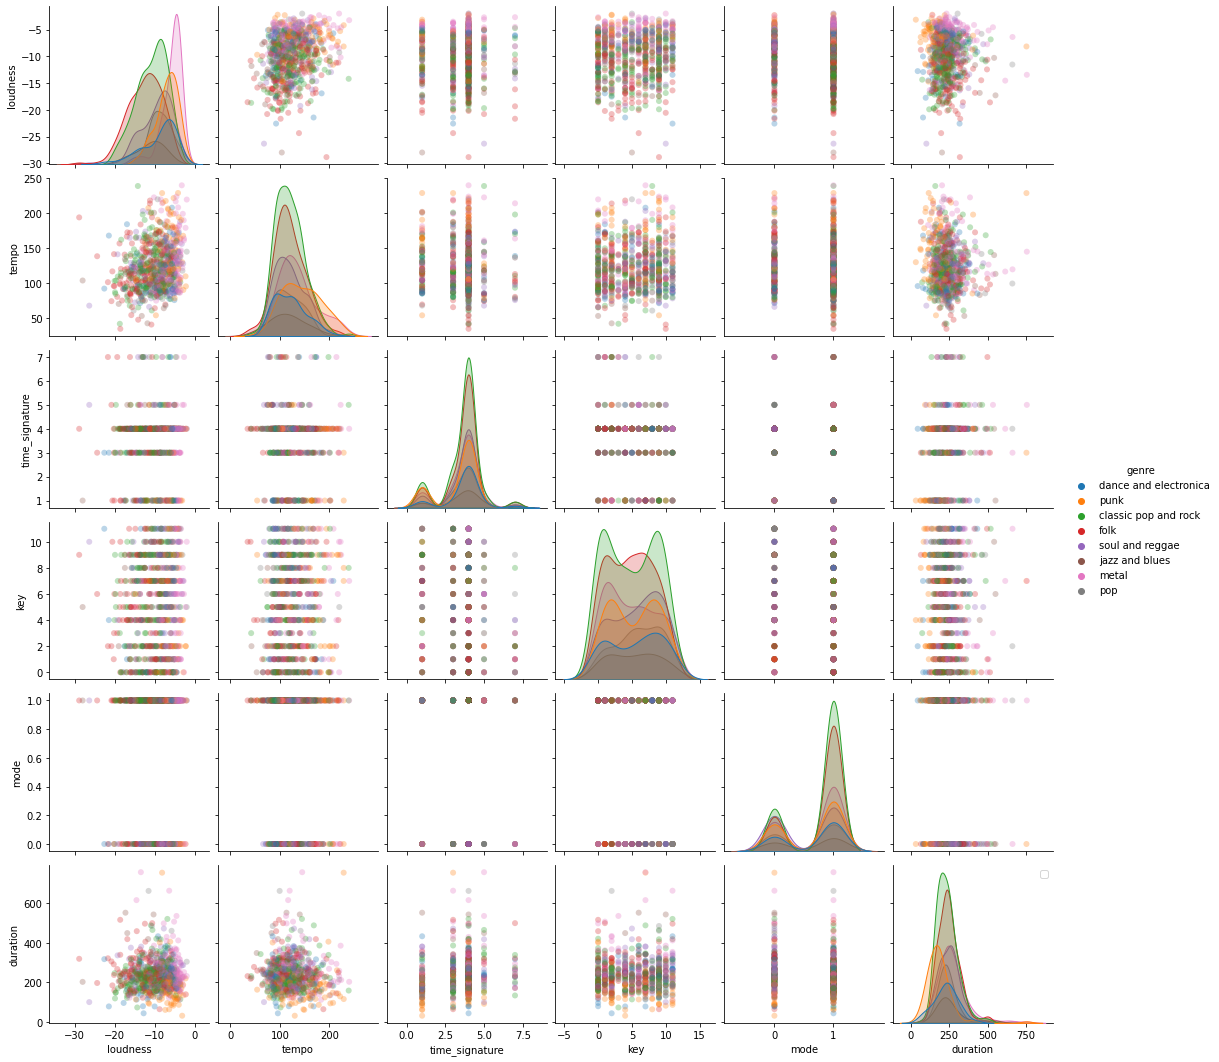

In [60]:
numeric_feat_and_target_df_sample = numeric_feat_and_target_df.sample(frac=0.1, replace=False, random_state=seed) #generate a reproducible sample of df2    
plot_cat_features(numeric_feat_and_target_df_sample[numerical_feat_and_target], 'genre', './figures/numeric_feature_target_rs.png');
# - impute categorical features ['time_signature', 'key', 'mode'] with mode
# - impute numeric features ['tempo', 'duration'] with mean 
# - impute numeric features ['loudness'] with median 

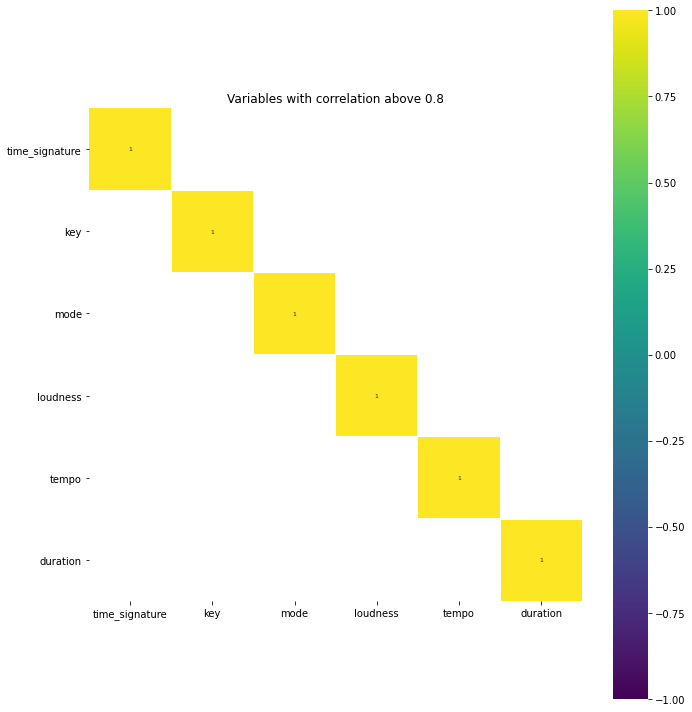

In [62]:
#correlation between numeric features
num_variables_corr = numeric_feat_and_target_df_sample[categorical_feat_list+continuous_feat_list].corr() 
fig = plt.figure(figsize=(10, 10))
ax = sns.heatmap(num_variables_corr[(num_variables_corr >= 0.8) | (num_variables_corr <= -0.8)],  #view correlations that are greater than abs(0.8)
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 6}, square=True)
ax.set_title('Variables with correlation above 0.8')
plt.tight_layout()
plt.show();
# there are no features that are highly correlated with one another

## Model Training

We want to use the tf-idf values, and original features as features to predict the **genre**.

However, since 10423 is a lot of dimensions and not all dimensions are equally important. I decided to use **PCA** on `vect_cols` and `tfidf_cols` to reduce the number of dimensions to **10** each and use these 20 principal components and `loudness`, `tempo`, `time_signature`, `key`, `mode`, `duration` as features instead.

Before that, let's split our data into training validation and testing dataset for evaluation later (80:20:20 split) and apply normalization

apply stratification on **genre** since classes is slightly imbalanced

### normalize data

In [64]:
features_df1.head(2)

,trackID,loudness,tempo,time_signature,key,mode,duration,vect_1,vect_2,vect_3,...,d_youth,d_yuh,d_zeit,d_zero,d_zone,d_zoo,d_zum,d_zur,d_zuruck,d_zwei
0,6654,-8.539062,104.3125,3.0,7.0,1.0,298.750,44.46875,-13.500000,26.250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5883,-4.324219,142.0000,3.0,6.0,0.0,236.125,46.06250,16.984375,-1.875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
vect_cols = [col for col in features_df1.columns if col.startswith('vect')]
len(vect_cols)

148

In [66]:
tfidf_cols = [col for col in features_df1.columns if col.startswith('d_')]
len(tfidf_cols)

10268

In [67]:
master_df = features_df1.merge(labels_df[['trackID', 'genre_le']].astype(np.int16), on = 'trackID')
master_df.head(1)

,trackID,loudness,tempo,time_signature,key,mode,duration,vect_1,vect_2,vect_3,...,d_yuh,d_zeit,d_zero,d_zone,d_zoo,d_zum,d_zur,d_zuruck,d_zwei,genre_le
0,6654,-8.539062,104.3125,3.0,7.0,1.0,298.75,44.46875,-13.5,26.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [83]:
# here
features_df1[numeric_feat] = features_df1[numeric_feat].astype(np.float16)
master_df = features_df1.merge(labels_df[['trackID', 'genre_le']].astype(np.int16), on = 'trackID')

master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8128 entries, 0 to 8127
Columns: 10424 entries, trackID to genre_le
dtypes: float16(10422), int16(2)
memory usage: 161.7 MB


In [68]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8128 entries, 0 to 8127
Columns: 10424 entries, trackID to genre_le
dtypes: float16(10422), int16(2)
memory usage: 161.7 MB


In [69]:
model_features = [col for col in features_df1.columns if col not in ('trackID', 'genre_le')]

In [70]:
master_df.shape

(8128, 10424)

In [71]:
master_df.isnull().sum()/len(master_df) * 100
# since nulls are a small % of total observations, drop them for this mvp. 

trackID                   0.000000
loudness                  0.123031
tempo                     0.135335
time_signature            0.110728
key                       0.184547
mode                      0.110728
duration                  0.110728
vect_1                    0.123031
vect_2                    0.098425
vect_3                    0.135335
vect_4                    0.147638
vect_5                    0.110728
vect_6                    0.147638
vect_7                    0.123031
vect_8                    0.098425
vect_9                    0.123031
vect_10                   0.123031
vect_11                   0.098425
vect_12                   0.159941
vect_13                   0.000000
vect_14                   0.000000
vect_15                   0.000000
vect_16                   0.000000
vect_17                   0.000000
vect_18                   0.000000
vect_19                   0.000000
vect_20                   0.000000
vect_21                   0.000000
vect_22             

In [72]:
master_df1 = master_df.dropna()
# check for nulls
master_df1.columns[master_df1.isna().any()].tolist()

[]

In [84]:
len(master_df1[master_df1.isin([np.inf, -np.inf]).any(1)])

67

In [85]:
master_df1.shape

(7742, 10424)

In [86]:
# drop rows that have infinity values
master_df2 =master_df1[~master_df1.isin([np.nan, np.inf, -np.inf]).any(1)]
master_df2.shape

(7675, 10424)

In [87]:
#let's prepare the data for models
y = master_df2['genre_le']
X_1 = master_df2[model_features]
    
#split data into 60% train, 20% val, 20% test    
X_train_val_1, X_test_1, y_train_val, y_test = train_test_split(X_1, y, test_size=0.2,random_state=seed,stratify=y)


In [88]:
features_to_scale = tfidf_cols + vect_cols
len(features_to_scale) == len(list(tfidf_cols)) + len(list(vect_cols))

True

In [89]:
X_train_val_1[features_to_scale].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6140 entries, 4231 to 5551
Columns: 10416 entries, d_aah to vect_148
dtypes: float16(10416)
memory usage: 122.0 MB


In [90]:
#feature scaling
scaler = MinMaxScaler()

X_train_val_1_scaled_cols_dataset = X_train_val_1[features_to_scale].to_numpy().astype(np.float64)
X_test_1_scaled_cols_dataset = X_test_1[features_to_scale].to_numpy().astype(np.float64)

#fit and transform train and validation set
X_train_val_1_scaled_cols_df = pd.DataFrame(scaler.fit_transform(X_train_val_1_scaled_cols_dataset), columns=[str(i) + "_scaled" for i in features_to_scale])

#but only transform the test set to prevent data leakage
X_test_1_scaled_cols_df = pd.DataFrame(scaler.transform(X_test_1_scaled_cols_dataset), columns=[str(i) + "_scaled" for i in features_to_scale])

In [91]:
X_train_val_1_scaled_cols_df.head(1)

,d_aah_scaled,d_abandon_scaled,d_abl_scaled,d_aboard_scaled,d_about_scaled,d_about alway_scaled,d_about call_scaled,d_about did_scaled,d_about everi_scaled,d_about hand_scaled,...,vect_139_scaled,vect_140_scaled,vect_141_scaled,vect_142_scaled,vect_143_scaled,vect_144_scaled,vect_145_scaled,vect_146_scaled,vect_147_scaled,vect_148_scaled
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.112908,0.140571,0.142084,0.133633,0.131673,0.130276,0.137676,0.117309,0.300923,0.002918


In [92]:
vect_scaled_cols = [str(i) + "_scaled" for i in vect_cols]
tfidf_scaled_cols = [str(i) + "_scaled" for i in tfidf_cols]


In [93]:
X_train_val_1_scaled_cols_df[vect_scaled_cols].head(1)

,vect_1_scaled,vect_2_scaled,vect_3_scaled,vect_4_scaled,vect_5_scaled,vect_6_scaled,vect_7_scaled,vect_8_scaled,vect_9_scaled,vect_10_scaled,...,vect_139_scaled,vect_140_scaled,vect_141_scaled,vect_142_scaled,vect_143_scaled,vect_144_scaled,vect_145_scaled,vect_146_scaled,vect_147_scaled,vect_148_scaled
0,0.605318,0.561348,0.377875,0.425457,0.691017,0.678688,0.562468,0.546857,0.49806,0.508076,...,0.112908,0.140571,0.142084,0.133633,0.131673,0.130276,0.137676,0.117309,0.300923,0.002918


In [94]:
# We have a lot of dimensions. So let's do dimensionality reduction
pca = PCA(n_components=10, random_state= seed)
X_train_pca = pca.fit_transform(X_train_val_1_scaled_cols_df)
X_test_pca = pca.transform(X_test_1_scaled_cols_df)

# applying PCA on vect_cols and tfidf_cols as a whole can only capture little variance
pca.explained_variance_ratio_

array([0.01848994, 0.01447636, 0.00985375, 0.00472821, 0.00405356,
       0.00380333, 0.00327625, 0.0032482 , 0.0031574 , 0.00299107])

In [95]:
# apply PCA on vect_cols and tfidf_cols separately
vect_pca_n_components = 10

vect_pca = PCA(n_components=vect_pca_n_components, random_state= seed)
X_train_vect_pca = vect_pca.fit_transform(X_train_val_1_scaled_cols_df[vect_scaled_cols])
X_test_vect_pca = vect_pca.transform(X_test_1_scaled_cols_df[vect_scaled_cols])

# the first 3 dimensions is able to capture most of the variance (60%). 
# Let's use all 10 principal components anyway
vect_pca.explained_variance_ratio_

array([0.34503796, 0.18596441, 0.07532829, 0.04179931, 0.03691864,
       0.02652308, 0.02142931, 0.02014234, 0.0172842 , 0.01615782])

In [96]:
# since dtm_tdidf has a wider matrix, i use more components to represent
tfidf_pca_n_components = 500

tfidf_pca = PCA(n_components=tfidf_pca_n_components, random_state= seed)
X_train_tfidf_pca = tfidf_pca.fit_transform(X_train_val_1_scaled_cols_df[tfidf_scaled_cols])
X_test_tfidf_pca = tfidf_pca.transform(X_test_1_scaled_cols_df[tfidf_scaled_cols])

sum(tfidf_pca.explained_variance_ratio_)*100
pkl.dump(vect_pca, open("./models/vect_pca.pkl","wb"))
pkl.dump(tfidf_pca, open("./models/tfidf_pca.pkl","wb"))

42.195775989876324

In [97]:
# convert np array to df so as to combine with master_df with non scaled cols
X_train_vect_pca_df = pd.DataFrame(X_train_vect_pca, columns=["vect_pca_" + str(i) for i in range(vect_pca_n_components)])
X_train_tfidf_pca_df = pd.DataFrame(X_train_tfidf_pca, columns=["tfidf_pca_" + str(i) for i in range(tfidf_pca_n_components)])

X_test_vect_pca_df = pd.DataFrame(X_test_vect_pca, columns=["vect_pca_" + str(i) for i in range(vect_pca_n_components)])
X_test_tfidf_pca_df = pd.DataFrame(X_test_tfidf_pca, columns=["tfidf_pca_" + str(i) for i in range(tfidf_pca_n_components)])


In [99]:
non_scaled_cols = categorical_feat_list+continuous_feat_list

In [ ]:
# X_train_val_1[non_scaled_cols].to_csv('./data/output/X_train_val_non_scaled_cols_1.csv', index=False)
# X_train_vect_pca_df.to_csv('./data/output/X_train_vect_pca_df.csv', index=False)
# X_train_tfidf_pca_df.to_csv('./data/output/X_train_tfidf_pca_df.csv')
# X_test_1[non_scaled_cols].to_csv('./data/output/X_test_non_scaled_cols_1.csv', index=False)
# X_test_vect_pca_df.to_csv('./data/output/X_test_vect_pca_df.csv', index=False)
# X_test_tfidf_pca_df.to_csv('./data/output/X_test_tfidf_pca_df.csv', index=False)

In [121]:
X_train_val_non_scaled_cols_1 = pd.read_csv('./data/output/X_train_val_non_scaled_cols_1.csv')
X_train_vect_pca_df = pd.read_csv('./data/output/X_train_vect_pca_df.csv')
X_train_tfidf_pca_df = pd.read_csv('./data/output/X_train_tfidf_pca_df.csv')
X_test_non_scaled_cols_1 = pd.read_csv('./data/output/X_test_non_scaled_cols_1.csv')
X_test_vect_pca_df = pd.read_csv('./data/output/X_test_vect_pca_df.csv')
X_test_tfidf_pca_df = pd.read_csv('./data/output/X_test_tfidf_pca_df.csv')

In [123]:
# # combine our pca df with original df that i didn't scale
X_train_val_2 = pd.concat([X_train_val_non_scaled_cols_1, X_train_vect_pca_df, X_train_tfidf_pca_df], axis=1)
X_test_2 = pd.concat([X_test_non_scaled_cols_1, X_test_vect_pca_df, X_test_tfidf_pca_df], axis=1)
# check if same number of rows after join
print(len(X_train_val_2) == len(X_train_val_1))
print(len(X_test_2) == len(X_test_1))

True
True


In [124]:
# check for nulls
X_train_val_2.columns[X_train_val_2.isna().any()].tolist()

[]

In [125]:
# check for nulls
X_test_2.columns[X_train_val_2.isna().any()].tolist()

[]

In [126]:
len(X_train_val_2) == len(y_train_val)

True

In [127]:
len(X_test_2) == len(y_test)

True

In [128]:
#split data into 60% train, 20% val, 20% test    
X_train_1, X_val_1, y_train, y_val = train_test_split(X_train_val_2, y_train_val, test_size=.25, random_state=seed,stratify=y_train_val)


In [129]:
print(X_train_1.shape)
print(X_val_1.shape)
print(X_test_2.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(4605, 516)
(1535, 516)
(1535, 516)
(4605,)
(1535,)
(1535,)


In [396]:
feature_name = list(X_train_1.columns.values)
categorical_feature = categorical_feat_list

# LGBM hyperparameter randomised gridsearch
lgbm_grid_parameters = {
    "objective" : ['multiclass'],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2], # determines the impact of each tree on the final outcome. for better accuracy, i coupled small learning rate with large num of iterations 
    "max_depth":[3,5,8], # limit how deep the trees grow to prevent overfitting
    "criterion": ["multi_logloss"], #metrics for multi-class
    "feature_fraction" : [0.4, 0.5, 0.6, 0.7], #to prevent overfitting, LGBM randomly selects part of features on each iteration (tree) if feature_fraction smaller than 1.0. For example, if you set it to 0.7, LightGBM will select 70% of features before training each tree
    "n_estimators":[100, 200, 300, 400, 500], #num of iterations
    "num_leaves" : [10,20,30,40,50], # to prevent overfitting, set num_leaf per estimator/tree,
    "min_data_in_leaf":[10], #to prevent overfitting, set a minimum number of data points needed in a child (leaf) node
    "min_split_gain" : [0.1, 0.5], #to prevent overfitting, set a minimum loss reduction required to make a further partition on a leaf node of the tree 
    "random_state" : [seed]}

lgbm_clf = lgb.LGBMClassifier()
lgbm_finder = RandomizedSearchCV(lgbm_clf, lgbm_grid_parameters,
                                 n_jobs=-1,
                                 refit='multi_logloss',
                                 cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = seed), 
                                 verbose=50,
                                 return_train_score=False )

In [397]:
lgbm_finder.fit(X_train_val_2, y_train_val,categorical_feature = categorical_feature, feature_name = feature_name)

#this returns a dict of the parameter setting that gave the best results on the hold out data
print('Best score reached: {} with params: {} '.format(lgbm_finder.best_score_, lgbm_finder.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
Best score reached: 0.6042345276872965 with params: {'random_state': 123, 'objective': 'multiclass', 'num_leaves': 20, 'n_estimators': 500, 'min_split_gain': 0.1, 'min_data_in_leaf': 10, 'max_depth': 8, 'learning_rate': 0.025, 'feature_fraction': 0.7, 'criterion': 'multi_logloss'} 


In [398]:
start = time.time()
lgbm_cv_model_1 = lgbm_finder.best_estimator_.fit(X_train_val_2, y_train_val,
        eval_set=[(X_train_val_2, y_train_val),(X_test_2, y_test)],
        eval_metric=['multi_logloss'],
        early_stopping_rounds=200, #when the performance of validation set can't improve for 200 rounds, stop iterating
        verbose=60)

end = time.time()
print('Total time spent: {}'.format(end-start))

Training until validation scores don't improve for 200 rounds
[60]	training's multi_logloss: 0.879885	valid_1's multi_logloss: 1.26566
[120]	training's multi_logloss: 0.550428	valid_1's multi_logloss: 1.14763
[180]	training's multi_logloss: 0.365929	valid_1's multi_logloss: 1.10385
[240]	training's multi_logloss: 0.250224	valid_1's multi_logloss: 1.08819
[300]	training's multi_logloss: 0.17419	valid_1's multi_logloss: 1.0831
[360]	training's multi_logloss: 0.122362	valid_1's multi_logloss: 1.08603
[420]	training's multi_logloss: 0.0869127	valid_1's multi_logloss: 1.09175
[480]	training's multi_logloss: 0.0625385	valid_1's multi_logloss: 1.10153
Early stopping, best iteration is:
[299]	training's multi_logloss: 0.175255	valid_1's multi_logloss: 1.08298
Total time spent: 37.58085083961487


In [399]:
y_gbm_test_preds_1 = lgbm_cv_model_1.predict(X_test_2).round(1)

print("LGBM Post randomised gridsearch test results:")
print(metrics.classification_report(y_test, y_gbm_test_preds_1))

pred_accuracy_score = accuracy_score(y_test, y_gbm_test_preds_1)
pred_recall_score = recall_score(y_test, y_gbm_test_preds_1, average='macro')
print('Prediction accuracy', pred_accuracy_score,' recall ', pred_recall_score)

LGBM Post randomised gridsearch test results:
              precision    recall  f1-score   support

           0       0.47      0.60      0.53       319
           1       0.56      0.14      0.23        97
           2       0.56      0.76      0.65       314
           3       1.00      0.03      0.06        67
           4       0.82      0.85      0.84       227
           5       0.84      0.58      0.68       137
           6       0.80      0.70      0.75       188
           7       0.58      0.55      0.57       186

    accuracy                           0.62      1535
   macro avg       0.70      0.53      0.54      1535
weighted avg       0.66      0.62      0.60      1535

Prediction accuracy 0.6221498371335505  recall  0.5277790711294539


In [361]:
le_name_mapping_list

[{'classic pop and rock': 0,
  'dance and electronica': 1,
  'folk': 2,
  'jazz and blues': 3,
  'metal': 4,
  'pop': 5,
  'punk': 6,
  'soul and reggae': 7}]

In [372]:
# get keys from each dict
labels_list = [*le_name_mapping_list[0]]

In [391]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, filename=None):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(filename, dpi=600);

In [393]:
# save model object for inference
pkl.dump(lgbm_cv_model_1, open("./models/lgbm_cv_model_1.pkl","wb"))

Normalized confusion matrix
[[0.60188088 0.01253918 0.25705329 0.         0.03448276 0.
  0.01880878 0.07523511]
 [0.28865979 0.1443299  0.24742268 0.         0.09278351 0.
  0.07216495 0.15463918]
 [0.16242038 0.00318471 0.76433121 0.         0.00636943 0.00955414
  0.01273885 0.04140127]
 [0.49253731 0.         0.41791045 0.02985075 0.         0.
  0.01492537 0.04477612]
 [0.07488987 0.         0.01762115 0.         0.85462555 0.
  0.04845815 0.00440529]
 [0.16788321 0.         0.13138686 0.         0.         0.57664234
  0.01459854 0.10948905]
 [0.04787234 0.0106383  0.04787234 0.         0.11170213 0.06382979
  0.69680851 0.0212766 ]
 [0.31182796 0.02150538 0.10752688 0.         0.         0.
  0.00537634 0.55376344]]


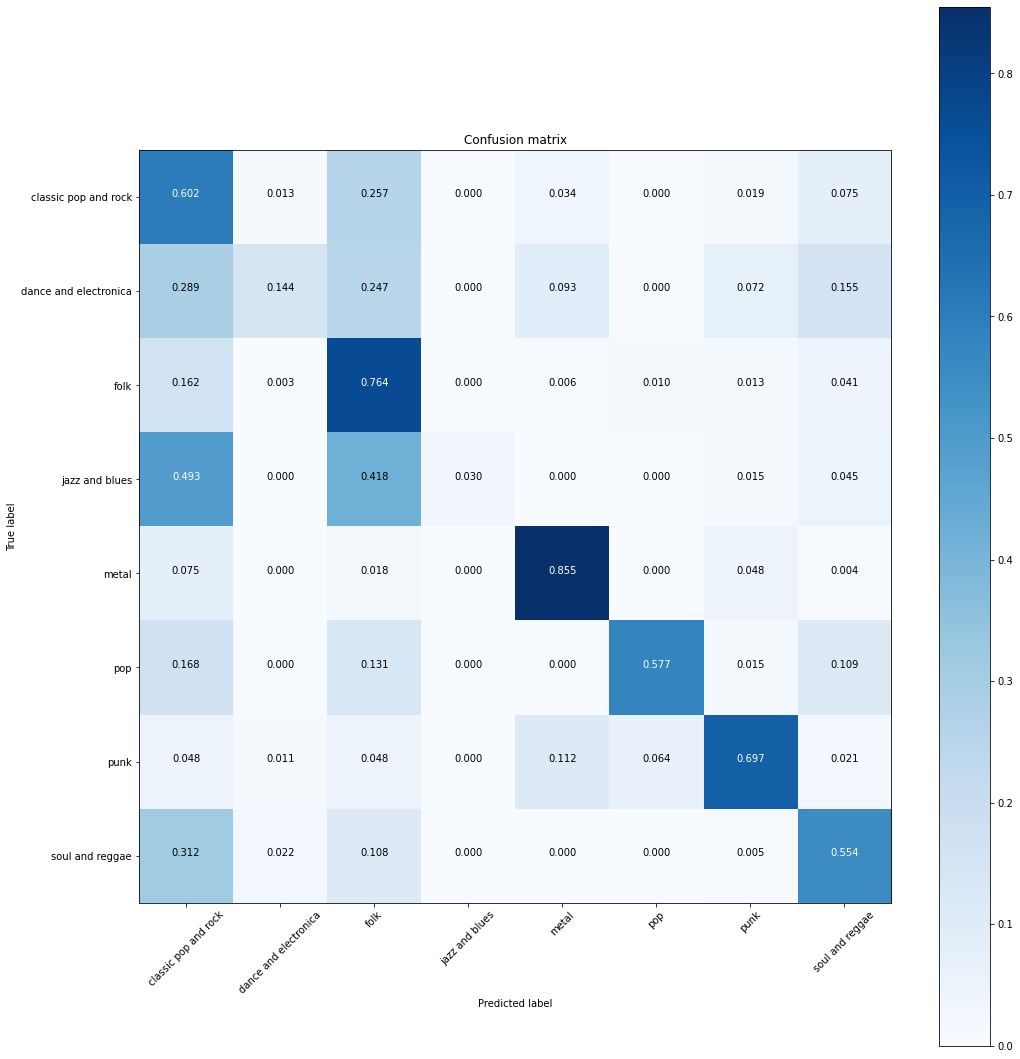

In [400]:
cnf_matrix = confusion_matrix(y_test, y_gbm_test_preds_1, labels=np.unique(labels_df[target_label_encode]))
plot_confusion_matrix(cnf_matrix, classes=labels_list,normalize=True, title='Confusion matrix', filename='./figures/conf_mat_lgbm1.png')

  `classic pop and rock`, `folk`, `metal`, `pop`, `punk`, `soul and reggae` have decent accuracy and recall
  
  `dance and electronica` and `jazz and blues` have very low acc. may be because there are fewer training data c.f. other classes (`dance and electronica` (6%),  `jazz and blues` (4%) cf. other classes 12-20%)